# Lab 3: MaxEnt model of phonotactic learning

**TODO 0**: Put your name and group members' name here.

**Xiang Fu**

Make sure that you can import the necessary packages. You might need to install `scipy`.

In [1]:
!pip3 install scipy

In [2]:
import itertools
import random
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import spearmanr

## Helper functions
You might find the `sliding_window` function useful for computing constraint violations over $n$ feature sets.

In [3]:
def sliding_window(lst, n):
    result = []
    for i in range(len(lst) - n + 1):
        window = lst[i:i+n]
        result.append(window)
    return result

## Step 0: Preamble
This notebook will guide you through implementing a (much simplified) version of Hayes & Wilson's MaxEnt phonotactic learner. We will work with the English onset example discussed in Tuesday's lecture.

## Step 1: Load the feature mapping data
Let's first load the data that provides a mapping between English phones and sets of feature values. Execute the following cell and examine the data.

In [64]:
feature_file = "/projectnb/lx496/najoung/lab3/EnglishFeatures.txt"
features_df = pd.read_csv(feature_file, delimiter="\t")
features_df = features_df.rename(columns={"Unnamed: 0": "phone"})
features_df

,phone,consonantal,approximant,sonorant,continuant,nasal,voice,spread,labial,coronal,anterior,strident,lateral,dorsal,high,back
0,B,+,-,-,-,0,+,0,+,0,0,0,0,0,0,0
1,CH,+,-,-,-,0,-,0,0,+,-,+,0,0,0,0
2,D,+,-,-,-,0,+,0,0,+,+,-,0,0,0,0
3,DH,+,-,-,+,0,+,0,0,+,+,-,0,0,0,0
4,F,+,-,-,+,0,-,0,+,0,0,0,0,0,0,0
5,G,+,-,-,-,0,+,0,0,0,0,0,0,+,0,0
6,JH,+,-,-,-,0,+,0,0,+,-,+,0,0,0,0
7,K,+,-,-,-,0,-,0,0,0,0,0,0,+,0,0
8,P,+,-,-,-,0,-,0,+,0,0,0,0,0,0,0
9,S,+,-,-,+,0,-,0,0,+,+,+,0,0,0,0


Now we will convert the above dataframe into a dictionary from phone strings to feature-value dictionaries. (If you don't like this data structure, feel free to use your own!)

In [65]:
feature_set_dict = {}
for row_d in features_df.to_dict(orient="records"):
    phone_name = row_d["phone"]
    del row_d["phone"]
    feature_set_dict[phone_name] = row_d
    
feature_set_dict

{'B': {'consonantal': '+',
  'approximant': '-',
  'sonorant': '-',
  'continuant': '-',
  'nasal': '0',
  'voice': '+',
  'spread': '0',
  'labial': '+',
  'coronal': '0',
  'anterior': '0',
  'strident': '0',
  'lateral': '0',
  'dorsal': '0',
  'high': '0',
  'back': '0'},
 'CH': {'consonantal': '+',
  'approximant': '-',
  'sonorant': '-',
  'continuant': '-',
  'nasal': '0',
  'voice': '-',
  'spread': '0',
  'labial': '0',
  'coronal': '+',
  'anterior': '-',
  'strident': '+',
  'lateral': '0',
  'dorsal': '0',
  'high': '0',
  'back': '0'},
 'D': {'consonantal': '+',
  'approximant': '-',
  'sonorant': '-',
  'continuant': '-',
  'nasal': '0',
  'voice': '+',
  'spread': '0',
  'labial': '0',
  'coronal': '+',
  'anterior': '+',
  'strident': '-',
  'lateral': '0',
  'dorsal': '0',
  'high': '0',
  'back': '0'},
 'DH': {'consonantal': '+',
  'approximant': '-',
  'sonorant': '-',
  'continuant': '+',
  'nasal': '0',
  'voice': '+',
  'spread': '0',
  'labial': '0',
  'coronal':

## Step 2: Define the constraints

Examples:

Single-phone constraints:

    *[+sonorant, +dorsal]
    
    *[+cont, +voice, -ant]

Two-phone constraints:

    *[^-voice, +anterior, +strident] [-approx]

    *[ ][+continuant]

Note that you have to have a way to take complementation (^) into consideration.
Empty bracket [ ] means "anything" (effectively "any consonant" here).

**TODO 1**: Write out all 23 constraints from Table 4 of [Hayes & Wilson 2008](https://linguistics.ucla.edu/people/hayes/papers/HayesAndWilsonPhonotactics2008.pdf) (pp 397--398).

**Important!** The Hayes & Wilson notation is a bit misleading in that it looks like complementation only applies to the top feature in the feature vector, but it should apply to all of the features: so something that might look like \*[^+a, +b, -c] in their notation is really *^[+a, +b, -c].

In [52]:
constraints = [
    {"name": "+son, +dors", "weight": 5.64, "comment": "", "examples": ""},
    {"name": "+cont, +voice, -ant", "weight": 3.28, "comment": "", "examples": ""},
    {"name": "-voice, +ant, +strid][-approx", "weight": 5.91, "comment": "", "examples": ""},
    {"name": "[][+cont]", "weight": 5.17, "comment": "", "examples": ""},
    {"name": "[][voice]", "weight": 5.37, "comment": "", "examples": ""},
    {"name": "+son][]", "weight": 6.66, "comment": "", "examples": ""},
    {"name": "-strid][+cons]", "weight": 4.40, "comment": "", "examples": ""},
    {"name": "[][+strid]", "weight": 1.31, "comment": "", "examples": ""},
    {"name": "+lab][^+approx, +cor", "weight": 4.96, "comment": "", "examples": ""},
    {"name": "-ant][^+approx, -ant", "weight": 4.84, "comment": "", "examples": ""},
    {"name": "+cont, +voice][]", "weight": 4.84, "comment": "", "examples": ""},
    {"name": "-cont, -ant][]", "weight": 3.17, "comment": "", "examples": ""},
    {"name": "[][-back]", "weight": 5.04, "comment": "", "examples": ""},
    {"name": "+ant, +strid][-ant", "weight": 2.80, "comment": "", "examples": ""},
    {"name": "+spread][^+back", "weight": 4.82, "comment": "", "examples": ""},
    {"name": "+cont, +voice, +cor", "weight": 2.69, "comment": "", "examples": ""},
    {"name": "+voice][^+approx, +cor", "weight": 2.97, "comment": "", "examples": ""},
    {"name": "+cont, -strid][^+approx, -ant", "weight": 2.06, "comment": "", "examples": ""},
    {"name": "[][^-cont, -voice, +lab][+cons]", "weight": 3.05, "comment": "", "examples": ""},
    {"name": "[][+cor][^+approx, -ant]", "weight": 2.06, "comment": "", "examples": ""},
    {"name": "+cont, -strid", "weight": 1.84, "comment": "", "examples": ""},
    {"name": "+strid][-ant", "weight": 2.10, "comment": "", "examples": ""},
    {"name": "-cont, -voice, +cor][^+approx, -ant", "weight": 1.70, "comment": "", "examples": ""}
]

print(constraints)
print(len(constraints)) # should print 23


[{'name': '+son, +dors', 'weight': 5.64, 'comment': '', 'examples': ''}, {'name': '+cont, +voice, -ant', 'weight': 3.28, 'comment': '', 'examples': ''}, {'name': '-voice, +ant, +strid][-approx', 'weight': 5.91, 'comment': '', 'examples': ''}, {'name': '[][+cont]', 'weight': 5.17, 'comment': '', 'examples': ''}, {'name': '[][voice]', 'weight': 5.37, 'comment': '', 'examples': ''}, {'name': '+son][]', 'weight': 6.66, 'comment': '', 'examples': ''}, {'name': '-strid][+cons]', 'weight': 4.4, 'comment': '', 'examples': ''}, {'name': '[][+strid]', 'weight': 1.31, 'comment': '', 'examples': ''}, {'name': '+lab][^+approx, +cor', 'weight': 4.96, 'comment': '', 'examples': ''}, {'name': '-ant][^+approx, -ant', 'weight': 4.84, 'comment': '', 'examples': ''}, {'name': '+cont, +voice][]', 'weight': 4.84, 'comment': '', 'examples': ''}, {'name': '-cont, -ant][]', 'weight': 3.17, 'comment': '', 'examples': ''}, {'name': '[][-back]', 'weight': 5.04, 'comment': '', 'examples': ''}, {'name': '+ant, +str

## Step 3: Loading the training data
Recall that the model learns from attested onsets. Let's load the training data that contains the onsets paired with their observation frequency.

In [66]:
training_file = "/projectnb/lx496/najoung/lab3/EnglishLearningData.txt"
training_df = pd.read_csv(training_file, delimiter="\t", header=None)
training_df = training_df.rename(columns={0: "onset", 1: "frequency"})
# Print the first 20 lines
training_df[:20]

,onset,frequency
0,K,2764
1,R,2752
2,D,2526
3,S,2215
4,M,1965
5,P,1881
6,B,1544
7,L,1225
8,F,1222
9,HH,1153


I’ve converted the training data into lists of tuples (phone sequence, frequency) for you. Again, if you don't like this data structure, feel free to use your own!

In [67]:
training_data = []
for row_d in training_df.to_dict(orient="records"):
    training_data.append(([phone for phone in row_d["onset"].split()], row_d["frequency"]))

print(training_data)

[(['K'], 2764), (['R'], 2752), (['D'], 2526), (['S'], 2215), (['M'], 1965), (['P'], 1881), (['B'], 1544), (['L'], 1225), (['F'], 1222), (['HH'], 1153), (['T'], 1146), (['P', 'R'], 1046), (['W'], 780), (['N'], 716), (['V'], 615), (['G'], 537), (['JH'], 524), (['S', 'T'], 521), (['T', 'R'], 515), (['K', 'R'], 387), (['SH'], 379), (['G', 'R'], 331), (['CH'], 329), (['B', 'R'], 319), (['S', 'P'], 313), (['F', 'L'], 290), (['K', 'L'], 285), (['S', 'K'], 278), (['Y'], 268), (['F', 'R'], 254), (['P', 'L'], 238), (['B', 'L'], 213), (['S', 'L'], 213), (['D', 'R'], 211), (['K', 'W'], 201), (['S', 'T', 'R'], 183), (['TH'], 173), (['S', 'W'], 153), (['G', 'L'], 131), (['HH', 'W'], 111), (['S', 'N'], 109), (['S', 'K', 'R'], 93), (['Z'], 83), (['S', 'M'], 82), (['TH', 'R'], 73), (['S', 'K', 'W'], 69), (['T', 'W'], 55), (['S', 'P', 'R'], 51), (['SH', 'R'], 40), (['S', 'P', 'L'], 27), (['DH'], 19), (['D', 'W'], 17), (['G', 'W'], 11), (['TH', 'W'], 4), (['S', 'K', 'L'], 1)]


In [70]:
def phoneme_to_features(phoneme, feature_set_dict):
    return feature_set_dict.get(phoneme, {})

def training_data_to_features(training_data, feature_set_dict):
    processed_training_data = []
    for onset_sequence, frequency in training_data:
        feature_sequence = [phoneme_to_features(phoneme, feature_set_dict) for phoneme in onset_sequence]
        processed_training_data.append((feature_sequence, frequency))
    return processed_training_data

processed_training_data = training_data_to_features(training_data, feature_set_dict)
processed_training_data


[([{'consonantal': '+',
    'approximant': '-',
    'sonorant': '-',
    'continuant': '-',
    'nasal': '0',
    'voice': '-',
    'spread': '0',
    'labial': '0',
    'coronal': '0',
    'anterior': '0',
    'strident': '0',
    'lateral': '0',
    'dorsal': '+',
    'high': '0',
    'back': '0'}],
  2764),
 ([{'consonantal': '-',
    'approximant': '+',
    'sonorant': '+',
    'continuant': '0',
    'nasal': '0',
    'voice': '0',
    'spread': '0',
    'labial': '0',
    'coronal': '+',
    'anterior': '-',
    'strident': '-',
    'lateral': '0',
    'dorsal': '0',
    'high': '0',
    'back': '0'}],
  2752),
 ([{'consonantal': '+',
    'approximant': '-',
    'sonorant': '-',
    'continuant': '-',
    'nasal': '0',
    'voice': '+',
    'spread': '0',
    'labial': '0',
    'coronal': '+',
    'anterior': '+',
    'strident': '-',
    'lateral': '0',
    'dorsal': '0',
    'high': '0',
    'back': '0'}],
  2526),
 ([{'consonantal': '+',
    'approximant': '-',
    'sonorant': 

## Step 4: Evaluating constraint violation

Say we have an onset **TH** and we want to see if this violates the constraint `*[+continuant, -strident]`. (Spoiler: it does)

Recall that **TH** is represented as:

```{'consonantal': '+','approximant': '-','sonorant': '-','continuant': '+','nasal': '0','voice': '-','spread': '0','labial': '0','coronal': '+','anterior': '+','strident': '-','lateral': '0','dorsal': '0','high': '0','back': '0’}```

Given how you represented the constraints like \*[+continuant, -strident], you need some way to evaluate how many times this constraint is violated by **TH**.

**TODO 2.1**: implement the function `compute_constraint_violations` that performs this evaluation. **Your implementation should be able to handle arbitrary length constraints and arbitrary length inputs.** For this, you might find the helper function `sliding_window` helpful for cutting up the input into chunks of size $n$.

**TODO 2.2** Provide a couple of test cases; your test should include the following cases:
* Single phone input, single phone constraint
* Multi phone input, single phone constraint
* Multi phone input, multi phone constraint


In [18]:
def compute_constraint_violations(phone_sequence, constraint_list):
    """
    Computes the number of violations of constraints in a given phone sequence.
    This function now accepts a list of constraints for multi-phone constraints.

    :param phone_sequence: List of dictionaries with feature values for each phone.
    :param constraint_list: List of dictionaries representing each constraint's features.
    :return: Number of violations of the constraint(s).
    """
    violation_count = 0  # Initialize the count of violations

    # Iterate through the list of constraints
    for constraint in constraint_list:
        # Use the sliding window function to generate sub-sequences for comparison
        sub_sequences = sliding_window(phone_sequence, len(constraint))

        for sub_seq in sub_sequences:
            # Check if the sub-sequence violates the constraint
            if any(phone.get(feature, '0') != value for phone, (feature, value) in zip(sub_seq, constraint.items())):
                violation_count += 1

    return violation_count


In [19]:
# Write tests for TODO 2.2 here

# Mock data for testing
th_features = [
    {'consonantal': '+', 'approximant': '-', 'sonorant': '-', 'continuant': '+', 'nasal': '0', 'voice': '-', 'spread': '0', 'labial': '0', 'coronal': '+', 'anterior': '+', 'strident': '-', 'lateral': '0', 'dorsal': '0', 'high': '0', 'back': '0'},
    {'consonantal': '+', 'approximant': '-', 'sonorant': '-', 'continuant': '+', 'nasal': '0', 'voice': '+', 'spread': '0', 'labial': '0', 'coronal': '+', 'anterior': '+', 'strident': '-', 'lateral': '0', 'dorsal': '0', 'high': '0', 'back': '0'}
]

# Single phone constraint
single_phone_constraint = {'continuant': '+', 'strident': '-'}

# Test cases
# Single phone input, single phone constraint
single_violation_count = compute_constraint_violations([th_features[0]], [single_phone_constraint])

# Multi-phone input, single phone constraint
multi_violation_count = compute_constraint_violations(th_features, [single_phone_constraint])

# Multi-phone input, multi-phone constraint
multi_phone_constraint = [{'continuant': '+', 'strident': '-'}, {'continuant': '+', 'strident': '-'}]
multi_phone_violation_count = compute_constraint_violations(th_features, multi_phone_constraint)

(single_violation_count, multi_violation_count, multi_phone_violation_count)


(0, 0, 0)

## Step 5: Computing the probability of a representation with the MaxEnt model

The MaxEnt model assigns **scores** to phonological representations, given constraints and weights assigned to each constraint:
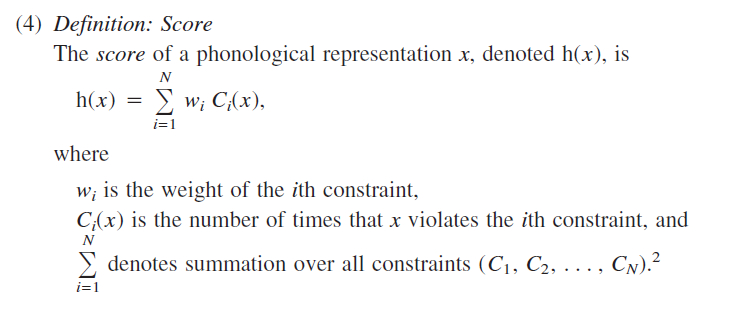

The MaxEnt value is computed from the scores as follows:
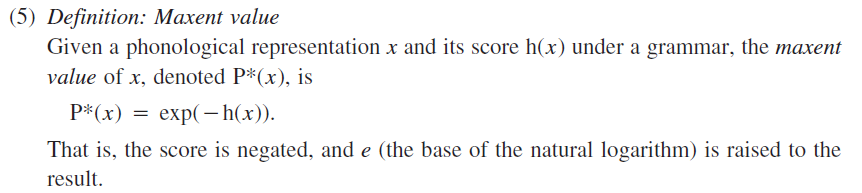

**TODO 3.1**: Define `compute_score` and `compute_maxent_val` functions that implement equations (4) and (5) above. Hint: our `compute_constraint_violations` function can compute $C_i(x)$, and the `initial_weights` variable is $[w_1, w_2...w_N]$ (currently just all 1s, because our model hasn't learned anything yet).

`np.exp()` can be used to raise $e$ to the negative score.

In [21]:
initial_weights = [1 for _ in range(len(constraints))]

def compute_score(representation, constraints, weights):
    """
    Compute the score of a phonological representation given constraints and weights.

    :param representation: The phonological representation to score.
    :param constraints: A list of constraint feature dictionaries.
    :param weights: A list of weights corresponding to each constraint.
    :return: The score h(x) for the representation.
    """
    # Compute the sum of weights times the number of violations for each constraint
    score = sum(weight * compute_constraint_violations(representation, [constraint])
                for weight, constraint in zip(weights, constraints))
    return score

def compute_maxent_val(score):
    """
    Compute the MaxEnt value of a phonological representation from its score.

    :param score: The score h(x) of the representation.
    :return: The MaxEnt value P*(x) for the representation.
    """
    # Compute the MaxEnt value as exp(-score)
    maxent_val = np.exp(-score)
    return maxent_val

mock_representation = [{'consonantal': '+', 'continuant': '+', 'voice': '-'}]  # TH

# Compute the score for this representation
mock_score = compute_score(mock_representation, constraints, initial_weights)

# Compute the MaxEnt value for this representation
mock_maxent_val = compute_maxent_val(mock_score)

(mock_score, mock_maxent_val)


(0, 1.0)

The probability of a representation is computed as follows:
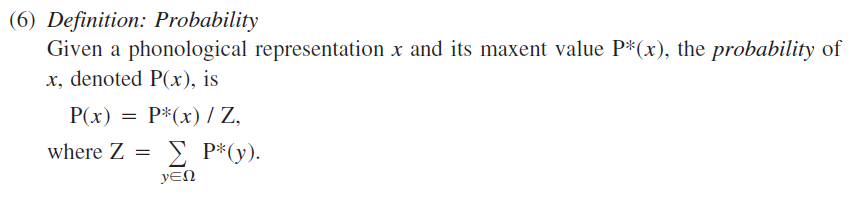

Note that this requires the computation of $Z$, sum of all Maxent values for all possible representations ($\Omega$).
But without defining $\Omega$, we cannot compute this value!

### Defining $\Omega$
We will make a simplifying assumption here that $\Omega$ is a set of phone sequences up to length 3 (which is not false if we restrict our analysis to English onsets). I've completed this part for you and stored the list of all possible phone sequences (with replacement) up to length 3 in `all_reps`.

In [22]:
def combinations_with_repetition(symbols, n):
    return list(itertools.chain.from_iterable(
        itertools.product(symbols, repeat=r) for r in range(1, n + 1)
    ))
    
all_reps = combinations_with_repetition(feature_set_dict, 3)
print(len(all_reps))
print(all_reps[100])

14424
('DH', 'F')


Now we can compute $Z$! We defined both $\Omega$ (`all_reps`) and $P^*(y)$ (`maxent_val()`). 

**TODO 3.2**: Define the function `compute_z()` that computes $Z$.

Note that it would be much better to compute this just once and reuse it, rather than computing this from scratch every time you compute the probability of a representation. So we'll store the output in a variable called `z_val`.

In [71]:
def compute_z(all_reps, constraints, weights):
    """
    Computes Z, the normalizing constant for the MaxEnt model.
    :param all_reps: List of all possible phone sequences (our Omega).
    :param constraints: List of constraint feature dictionaries.
    :param weights: List of weights corresponding to each constraint.
    :return: The value of Z.
    """
    # Compute the MaxEnt value for each representation and sum them
    z = sum(np.exp(-compute_score(rep, constraints, weights)) for rep in all_reps)
    return z

z_val = compute_z(all_reps, constraints, initial_weights)
z_val


14424.0

**TODO 3.3**: Finally we have everything we need to compute the probability. Define the function `compute_probability` that computes the probability of a given representation. You might want to specify `z_val` as one of its arguments, so that `z_val` can be computed only once and be reused.

In [72]:
# Specifying z_val as one of this function's arguments is recommended
# If not, you'll be wasting a lot of compute re-calculating a constant value.
def compute_probability(representation, constraints, weights, z_val):
    """
    Computes the probability of a given phonological representation.

    :param representation: The phonological representation to compute probability for.
    :param constraints: List of constraint feature dictionaries.
    :param weights: List of weights corresponding to each constraint.
    :param z_val: Precomputed normalization constant Z for the MaxEnt model.
    :return: The probability of the representation.
    """
    # First compute the score for the representation
    score = compute_score(representation, constraints, weights)
    # Compute the MaxEnt value for the representation
    maxent_val = compute_maxent_val(score)
    # Compute the probability of the representation using the MaxEnt value and Z
    probability = maxent_val / z_val
    return probability
    

In [73]:
mock_representation = [{'consonantal': '+', 'continuant': '+', 'voice': '-'}]  # TH
probability_of_representation = compute_probability(mock_representation, constraints, initial_weights, z_val)
probability_of_representation

6.932889628397117e-05

## Step 6: Defining the objective function

The goal of the learner, as we discussed in Tuesday's lecture, is to learn a set of weights that maximize the probability of the training data. 
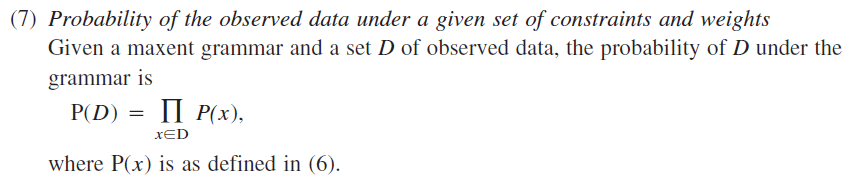

But products of small values can lead to numeric underflow, so we'll use $log(P(D))$ instead:

$log(P(D)) = \sum_{x \in D} log(P(x))$

**TODO 4**: Define the function `log_probability_data` that computes $log(P(D))$. You already have `compute_probability` defined, so this shouldn't be hard! Make sure that frequency must be taken into account: you can multiply the logprob of $x$ by frequency before summing.

Make sure that one of the arguments to your function is the weight array (`weights`), because we'll be using this function as the optimization objective (i.e., maximize log probability of the data)

In [84]:
def log_probability_data(training_data, constraints, weights, z_val):
    """
    Computes the log probability of the observed data under a given set of constraints and weights.

    :param training_data: Observed data as a list of tuples (representation, frequency).
    :param constraints: List of constraint feature dictionaries.
    :param weights: List of weights corresponding to each constraint.
    :param z_val: Precomputed normalization constant Z for the MaxEnt model.
    :return: Log probability of the training data.
    """
    # Initialize the log probability sum
    log_prob_sum = 0
    
    # Loop through each observed data point in the training data
    for representation, frequency in training_data:
        # Compute the probability of the representation
        prob = compute_probability(representation, constraints, weights, z_val)
        # Take the log of the probability and multiply by frequency, then add to sum
        log_prob_sum += frequency * np.log(prob)
        
    return log_prob_sum


In [87]:
log_prob_data = log_probability_data(processed_training_data, constraints, weights, z_val)
log_prob_data

-303014.7435696678

## Step 7: Optimization

We will move away from the method used in Hayes & Wilson and just directly optimize for the log probability of the data using an off-the-shelf optimizer.

**TODO 5**: In the `minimize` function call below, modify `-log_probability_data()` to supply all arguments to the function as you defined it, _except_ for the weights. Instead, in the position of the `weights` argument, place `x`.

For example, if your definition was `log_probability data(a, b, weights, c, d)`, write `-log_probability_data(actual_a, actual_b, x, actual_c, actual_d)` below.

In [76]:
hayes_wilson_initial_weights = [
    5.64, 3.28, 5.91, 5.17, 5.37, 6.66, 4.40, 1.31, 4.96, 4.84,
    4.84, 3.17, 5.04, 2.80, 4.82, 2.69, 2.97, 2.06, 3.05, 2.06,
    1.84, 2.10, 1.70
]

In [81]:
# Ideally don't touch anything in this cell except for the arguments to log_probability_data()
np.set_printoptions(suppress=True)
optim_results = minimize(
    lambda x: -log_probability_data(processed_training_data, constraints, x, z_val),
    hayes_wilson_initial_weights,
    bounds=[(0, 10) for _ in hayes_wilson_initial_weights],
    method='Nelder-Mead',
)
print(optim_results.x)

[5.64 3.28 5.91 5.17 5.37 6.66 4.4  1.31 4.96 4.84 4.84 3.17 5.04 2.8
 4.82 2.69 2.97 2.06 3.05 2.06 1.84 2.1  1.7 ]


The following two print statements will print the difference pre- and post-optimization of the weights. If your optimizer worked (which it should), the second value should be larger than the first value (because we are maximizing logprob of the data).

If you used different argument specifications than mine for `log_probability_data` you would need to change the arguments accordingly. The key point here is that the weight argument passed to the first line is just [1,1,1,...1] (`initial_weights`) and the weight argument passed to the second line is the optimized set of weights (of the same length).

In [83]:
allsum_maxent_val = z_val

print(log_probability_data(mock_training_data, constraints, initial_weights, allsum_maxent_val))
print(log_probability_data(mock_training_data, constraints, optim_results.x, allsum_maxent_val))


-9.576648764883153
-9.576648764883153


The following two cells test whether the weights we found correlate with the original Hayes and Wilson weights for the 23 constraints in Table 4. If you have the correct results, you will have something like 0.28 Spearman correlation --- note that we don't get a statistically significant result! This is not entirely surprising given that we've dramatically simplified the original learning model (e.g., we haven't implemented the universal constraint set; we are just ranking the constraints that they identified). 

In [79]:
hayes_wilson_weights = [
    5.64,
    3.28,
    5.91,
    5.17,
    5.37,
    6.66,
    4.40,
    1.31,
    4.96,
    4.84,
    4.84,
    3.17,
    5.04,
    2.80,
    4.82,
    2.69,
    2.97,
    2.06,
    3.05,
    2.06,
    1.84,
    2.10,
    1.70
]

In [80]:
from scipy.stats import spearmanr

correlation, p_value = spearmanr(optim_results.x, hayes_wilson_weights)
correlation, p_value

(0.9999999999999999, 7.469380058456733e-166)